In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt 

# 1-D Truss Stiffness

The following code shows how to create a (1) local stiffness matrix for a truss element (2) a local to global map (3) assemble the global system matrix 

### Create the coordinates and the element information

In [9]:
# The coordinates of each node 
coordinates = {0:0.,1:1.,2:4.,3:5.}

The element dictionary contains for each element the product of the cross sectional area times the 
Young's modulus, the global node index corresponding to the local `i` and `j` nodes.

In [10]:
# Create the element dictionary.  
elements = {} 
elements[0] = {'AE':4., 'i':0, 'j':1}
elements[1] = {'AE':20., 'i':1, 'j':2}
elements[2] = {'AE':30., 'i':2, 'j':3}
print(elements)

{0: {'AE': 4.0, 'j': 1, 'i': 0}, 1: {'AE': 20.0, 'j': 2, 'i': 1}, 2: {'AE': 30.0, 'j': 3, 'i': 2}}


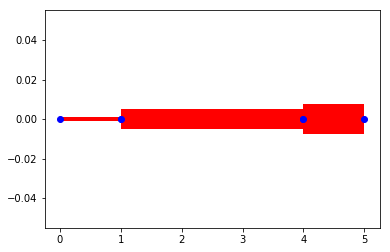

In [11]:
# Plot the elements 
for e in elements:
    elt = elements[e]
    plt.plot([coordinates[elt['i']],coordinates[elt['j']]], np.zeros(2),'-r',linewidth=elt['AE'],solid_capstyle="butt" )
    plt.plot([coordinates[elt['i']],coordinates[elt['j']]], np.zeros(2),'bo' )

### Create the local stiffness matrix

Create the function that, given an element number, it returns the local stiffness matrix

In [12]:
# The local element stiffness matric
# @param[in] elts the element disctionary
# @param[in] crds the coordinates of the element nodes
# @param[in] e the element lable
# @return the local element stiffness matrix
def local_stiffness(elts,crds,e):
    # Compute the lenght of the element 
    L = abs(crds[elts[e]['j']] - crds[elts[e]['i']])
    AEL = elts[e]['AE']/L
    return AEL*np.array([[1.,-1.],[-1.,1.]]) 

In [13]:
print( local_stiffness(elements,coordinates,1) )

[[ 6.66666667 -6.66666667]
 [-6.66666667  6.66666667]]


### Create the local to global map

In [14]:
# The local to global map
# @param[in] element dictionary
# @param[in] element id
# @param[in] local dof ('i' or 'j')
# return global dof
def local_to_global_map(elts, e, dof_idx):
    return elts[e][dof_idx] 

### Assemble the global stiffness matrix
We assemble the global stiffness matrix by first creating a square matrix of size $n$, with $n$ being the number of global degrees of freedom. Then we add the contribution from each element.

In [29]:
# Define the global stiffness 
K = np.zeros((4,4))

In [30]:
# Loop over all elements
for e in elements.keys():
    
    # Get the local stiffness matrix for element e
    ke = local_stiffness(elements,coordinates,e)
    
    # Loop over all local degrees of freedom 
    for z_num,z in enumerate('ij'):
        
        # Get the global degree of freedom of the local "i" index
        global_z = local_to_global_map(elements,e,z)
        
        for k_num,k in enumerate('ij'):
            
            # Get the global degree of freedom of the local "j" index
            global_k = local_to_global_map(elements,e,k)
            
            # Add the contribution to the global matrix
            K[global_z,global_k] += ke[z_num,k_num]      

In [31]:
print(K)

[[  4.          -4.           0.           0.        ]
 [ -4.          10.66666667  -6.66666667   0.        ]
 [  0.          -6.66666667  36.66666667 -30.        ]
 [  0.           0.         -30.          30.        ]]


### Create the load vector 

In [32]:
# The load vector P contains external loads if known, otherwise 0
P = np.zeros( K.shape[0])
P[2] = 10

### Apply boundary conditions
Remember applying boundary conditions takes place in a few steps:
1. we zero out the row of the degree of freedom
2. we place 1 on the diagonal 
3. we place the value of the displacement in the "load" vector

In [33]:
# The index of the global degree of freedom we are constraining 
dirichlet_index = [0]
dirichlet_value = [0]

In [34]:
# Zero out the rows of k
print(K)
# Save a copy for later
K_unconstrained = K*1
for i in dirichlet_index:
    K[i,:] *= 0 # zeros out the row
    K[i,i] = 1 # puts one on the diagonal
print(K)

[[  4.          -4.           0.           0.        ]
 [ -4.          10.66666667  -6.66666667   0.        ]
 [  0.          -6.66666667  36.66666667 -30.        ]
 [  0.           0.         -30.          30.        ]]
[[  1.          -0.           0.           0.        ]
 [ -4.          10.66666667  -6.66666667   0.        ]
 [  0.          -6.66666667  36.66666667 -30.        ]
 [  0.           0.         -30.          30.        ]]


In [35]:
# Set the value in the "load" vector
for i in dirichlet_index:
    P[i] = dirichlet_value[i]

### Solve for the displacements

In [36]:
# Solve for our unknown displacements
u = la.solve(K,P)
print(u)

[-8.8817842e-16  2.5000000e+00  4.0000000e+00  4.0000000e+00]


(-1, 10)

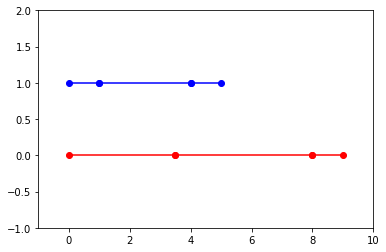

In [249]:
# Plot the deformed truss
# Plot the elements 
for e in elements:
    elt = elements[e]
    plt.plot([coordinates[elt['i']]+u[elt['i']],coordinates[elt['j']]+u[elt['j']]], np.zeros(2),'-ro')
    plt.plot([coordinates[elt['i']],coordinates[elt['j']]], np.zeros(2)+1,'-bo' )
plt.ylim([-1,2])
plt.xlim([-1,10])

### Let's look at the eigenvalues/eigenvectors
The eigenvectors of `K` tell you the modes of deformation and the corresponding eigenvalues the energy associated with that deformation. 

In [250]:
# Get the eigenvalues and eigenvectors
print(K_unconstrained)
eigenvalues, eigenvectors = la.eig(K_unconstrained)
print(eigenvalues)
print(eigenvectors)

[[  4.          -4.           0.           0.        ]
 [ -4.          10.66666667  -6.66666667   0.        ]
 [  0.          -6.66666667  36.66666667 -30.        ]
 [  0.           0.         -30.          30.        ]]
[6.39859454e+01 1.36958434e+01 1.64414773e-15 3.65154458e+00]
[[ 0.00625424 -0.35403799  0.5        -0.79032777]
 [-0.09379161  0.85817424  0.5        -0.0688485 ]
 [ 0.7463826  -0.17751141  0.5         0.40174957]
 [-0.65884523 -0.32662483  0.5         0.4574267 ]]


(-1, 10)

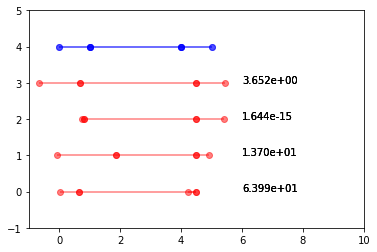

In [251]:
# Plot the eigenvectors
for i_idx,i in enumerate(eigenvalues):
    u = eigenvectors[i_idx]
    for e in elements:
        elt = elements[e]
        plt.plot([coordinates[elt['i']],coordinates[elt['j']]], np.zeros(2)+4,'-ob',alpha=0.25,solid_capstyle="butt" )
        plt.plot([coordinates[elt['i']]+u[elt['i']],coordinates[elt['j']]+u[elt['j']]], np.zeros(2)+i_idx,'-ro',alpha=0.5,solid_capstyle="butt" )
        plt.text(6,i_idx,'%.3e'%i)
plt.ylim([-1,5])
plt.xlim([-1,10])

In [252]:
ke = local_stiffness(elements,coordinates,e)

In [253]:
l,v = la.eig(ke)